# Setup

Run `# pip install neat-python` to get neat-python installed

In [1]:
import neat
from pytorch_neat.cppn import create_cppn
import torch
import numpy as np
from matplotlib import pyplot as plt

In [2]:
size=128
x, y = np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))
xs = [t for t in torch.tensor(np.stack([x.flatten(), y.flatten()]))]
print(xs[0].shape)

torch.Size([16384])


In [3]:
# Load in the config 
config_file = 'config_color'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                      neat.DefaultSpeciesSet, neat.DefaultStagnation,
                      config_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


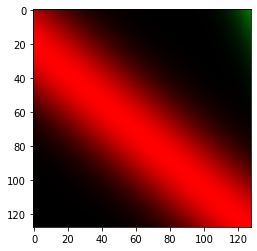

In [8]:
# Create a new population and pic a random output
p_new = neat.Population(config) # New, random population
keys = list(p_new.population.keys())
genome = p_new.population[keys[0]]
nodes = create_cppn(genome, config, ['x', 'y'], ['r','g','b']+list(range(len(genome.nodes)-3)))
[r_node, g_node, b_node] = nodes
out_im = torch.stack([r_node.activate(xs, xs[0].shape).reshape(size, size),
                      g_node.activate(xs, xs[0].shape).reshape(size, size),
                      b_node.activate(xs, xs[0].shape).reshape(size, size)])
plt.imshow(out_im.permute(1, 2, 0))

In [9]:
print(genome)

Key: 1
Fitness: None
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.27404619433587296, response=1.0434588953707975, activation=gauss, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-2.998234524815875, response=0.9776771761357281, activation=gauss, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-2.9975100394690473, response=0.6768746023851406, activation=identity, aggregation=sum)
	9603 DefaultNodeGene(key=9603, bias=2.3214659352859246, response=0.7255309898818441, activation=gauss, aggregation=sum)
	9604 DefaultNodeGene(key=9604, bias=-0.10647304006767001, response=1.3580044084684284, activation=gauss, aggregation=sum)
	9605 DefaultNodeGene(key=9605, bias=2.3177226632156844, response=1.0654325139004286, activation=sin, aggregation=sum)
	9606 DefaultNodeGene(key=9606, bias=-1.406054978767505, response=1.3679962974857165, activation=identity, aggregation=sum)
	9607 DefaultNodeGene(key=9607, bias=-1.2857015077887877, response=0.8530312864309071, activation=tanh, aggregation=sum)
	9608 Default

In [10]:
mse = torch.nn.MSELoss()
target_im = out_im*0.99 # Use this as a target (or do torch.rand(3, 128, 128))
def eval_genomes(genomes, config, target_im=target_im):
  for genome_id, genome in genomes:
    nodes = create_cppn(genome, config, ['x', 'y'], ['r','g','b']+list(range(len(genome.nodes)-3)))
    [r_node, g_node, b_node] = nodes
    out_im = torch.stack([r_node.activate(xs, xs[0].shape).reshape(size, size),
                          g_node.activate(xs, xs[0].shape).reshape(size, size),
                          b_node.activate(xs, xs[0].shape).reshape(size, size)])
    error = mse(target_im, out_im)
    genome.fitness = float(1-error)

In [11]:
# Now evolve a new population to try and match that:

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Run for up to 300 generations.
winner = p.run(eval_genomes, 50)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))


 ****** Running generation 0 ****** 

Population's average fitness: -7.06921 stdev: 5.43310
Best fitness: 0.21856 - size: (11, 12) - species 1 - id 158
Average adjusted fitness: 0.802
Mean genetic distance 3.960, standard deviation 0.280
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   300     -7.1    0.802     0
Total extinctions: 0
Generation time: 0.282 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.34280 stdev: 3.02550
Best fitness: 0.83357 - size: (11, 12) - species 1 - id 499
Average adjusted fitness: 0.812
Mean genetic distance 3.638, standard deviation 0.292
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   300     -4.3    0.812     0
Total extinctions: 0
Generation time: 0.290 sec (0.286 average)

 ****** Running generation 2 ****** 

Population's average fitness: -3.73651 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


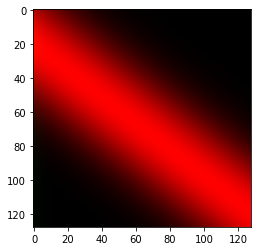

In [12]:
# View the 'best 
genome = winner
nodes = create_cppn(genome, config, ['x', 'y'], ['r','g','b']+list(range(len(genome.nodes)-3)))
[r_node, g_node, b_node] = nodes
out_im = torch.stack([r_node.activate(xs, xs[0].shape).reshape(size, size),
                      g_node.activate(xs, xs[0].shape).reshape(size, size),
                      b_node.activate(xs, xs[0].shape).reshape(size, size)])
plt.imshow(out_im.permute(1, 2, 0))

In [31]:
# print(winner)

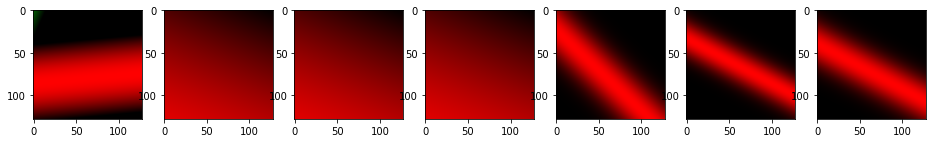

In [14]:
# View the evolution over time
fig, axs = plt.subplots(1, 7, figsize=(16, 4))
for i, gen in enumerate(range(4, 35, 5)):
    p_gen = neat.Checkpointer.restore_checkpoint(f'neat-checkpoint-{gen}')
    # View the 'best 
    keys = list(p_gen.population.keys())
    genome = p_gen.population[keys[0]]
    nodes = create_cppn(genome, config, ['x', 'y'], ['r','g','b']+list(range(len(genome.nodes)-3)))
    [r_node, g_node, b_node] = nodes
    out_im = torch.stack([r_node.activate(xs, xs[0].shape).reshape(size, size),
                        g_node.activate(xs, xs[0].shape).reshape(size, size),
                        b_node.activate(xs, xs[0].shape).reshape(size, size)])
    axs[i].imshow(out_im.clip(0, 1).permute(1, 2, 0))

In [15]:
!rm neat-checkpoint* # Clean up the save files